# Transformations for 3D medical images

In [1]:
# export
# default_exp augment
import torchvision
import torch
import fastai
from fastai.basics import *
from fastai.vision.augment import *

In [2]:
#!ln -s ../faimed3d/ faimed3d

In [3]:
# export
from faimed3d.basics import *

## Resizing

In [4]:
# export

@patch
def resize_3d(t: (TensorDicom3D), size: int):
    
    '''
    A function to resize a 3D image using torch.nn.functional.grid_sample
    
    Taken form the offical documention: 
        Given an input and a flow-field grid, computes the output using input values and pixel locations from grid.
        In the spatial (4-D) case, for input with shape (N,C,Hin,Win) and with grid in shape (N, Hout, Wout, 2), the output will have shape (N, C, Hout,Wout)
        
        In the case of 5D inputs, grid[n, d, h, w] specifies the x, y, z pixel locations for interpolating output[n, :, d, h, w]. 
        mode argument specifies nearest or bilinear interpolation method to sample the input pixels.
        
    Workflow of this function: 
    1. create a fake RGB 3D image through generating fake color channels.
    2. add a 5th batch dimension
    3. create a flow-field for rescaling:
        a. create a 1D tensor giving a linear progression from -1 to 1
        b. creat a mesh-grid (the flow field) from x,y,z tensors from (a)
    4. resample the input tensor according to the flow field
    5. remove fake color channels and batch dim, returning only the 3D tensor
        
    Args:
        t (Tensor): a Rank 3 Tensor to be resized
        new_dim (int): a tuple with the new x,y,z dimensions of the tensor after resize
        
    '''
    if type(size) in (tuple, fastuple) and len(size) == 3:
        z,x,y = size # for a reason, I do currently not understand, order of the axis changes from resampling. flipping the order of x,y,z is the current workaround
    else:
        raise ValueError('"size" must be a tuple with length 3, specifying the new (x,y,z) dimensions of the 3D tensor')
    
    t = torch.stack((t,t,t)) # create fake color channel
    t = t.unsqueeze(0).float() # create batch dim    

    x = torch.linspace(-1, 1, x) # create resampling 'directions' for pixels in each axis
    y = torch.linspace(-1, 1, y)
    z = torch.linspace(-1, 1, z)

    meshx, meshy, meshz = torch.meshgrid((x, y, z)) # 
    grid = torch.stack((meshy, meshx , meshz), 3) # create flow field. x and y need to be switched as otherwise the images are rotated. 
    if t.device.type == 'cuda': grid = grid.cuda()
    grid = grid.unsqueeze(0) # add batch dim
    t_resized = F.grid_sample(t, grid, align_corners=True, mode = 'bilinear') # rescale the 5D tensor
    return t_resized[0,0,:,:,:].permute(2,0,1).contiguous() # remove fake color channels and batch dim, reorder the image (the Z axis has moved to the back...)

class Resize3D(RandTransform):
    split_idx,order = None, 1
    "Resize a 3D image"
    
    def __init__(self, size, **kwargs): 
        size = _process_sz_3d(size)
        store_attr()
        super().__init__(**kwargs)

    def encodes(self, x: TensorDicom3D): 
        x = x.resize_3d(self.size)
        return x if x.device.type == 'cpu' else x.cuda()
    
def _process_sz_3d(size):
    if len(size) == 2: size=(size[0],size[1], size[1])
    return fastuple(size[0],size[1],size[2])

In [5]:
Resizer = Resize3D((10,50,50))
original = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM', return_normalized = True)
im = Resizer(original, split_idx = 0)
original.shape, im.shape

(torch.Size([31, 736, 736]), torch.Size([10, 50, 50]))

## Flipping

In medical images, the left and right side often cannot be differentiated from each other (e.g. scans of the head, hand, knee, ...). Therfore the image orientation is stored in the image header, enabeling the viewer system to accuratly display the images. 
For deep learning, only the pixel array is extracted, so the header information is lost. When displaying only the pixel array, the images might already be displayed flipped or in inverted slice order. So, implementing vertical/horizontal flipping as well as flipping alongside the z axis can be used for data augmentation.  
  
Using the `@Transform` decorator makes the transform function a callable for the Transform class. This gives extra handy functionalty to the function, e.g. if the type does not match, the input will just be returned:

```python
@Transform
def f(x: TensorDicom3D): return 1
im = read_medical_3d_image('../../data/dl-prostate-mapping/train/Gesund/A0042197734/T2/DICOM')
f(im)
```
```
    1
```

```python
f(tensor(5.)), f('a')
```
```
    tensor(5.), 'a'
```

using the `@patch` decorator also allows usuage as callable for `TensorDicom3D` in a `RandTransform` calss 

In [6]:
# export

@patch
def flip_ll_3d(t: TensorDicom3D): 
    "flips an image laterolateral"
    return t.flip(-1) # works on 3D images and 4D batchs

@patch
def flip_ap_3d(t: TensorDicom3D):
    "flips an image anterior posterior"
    return t.flip(-2)

@patch
def flip_cc_3d(t: TensorDicom3D):
    "flips an image cranio caudal"
    return t.flip(-3)


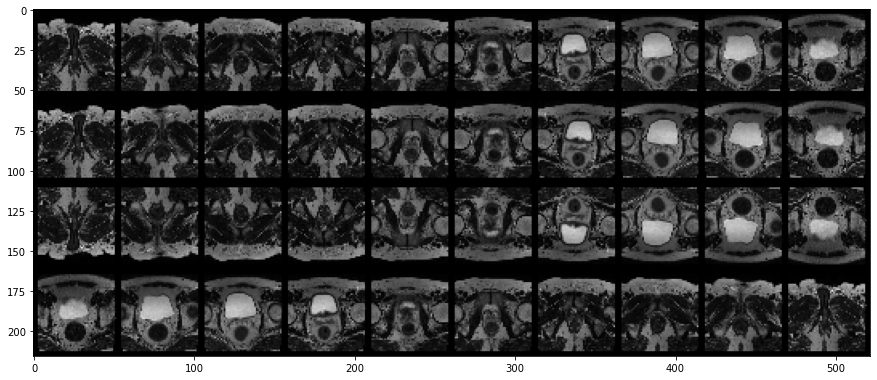

In [7]:
show_multiple_3d_images(torch.stack((im, flip_ll_3d(im), flip_ap_3d(im), flip_cc_3d(im))))

In [8]:
# export

class RandomFlip3D(RandTransform):
    "Randomly flip alongside any axis with probability `p`"
    def __init__(self, p=0.75): 
        super().__init__(p=p)
        
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.axis = random.randint(1, 3)*-1  # add a random integer for axis to rotate
        
    def encodes(self, x:TensorDicom3D): 
        return x.flip(self.axis)

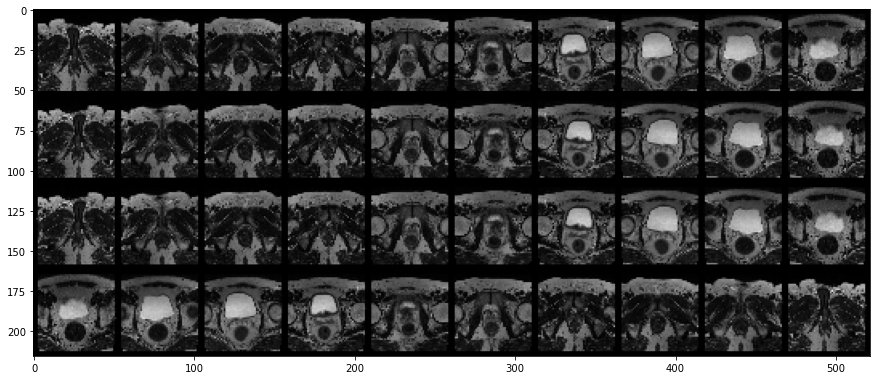

In [9]:
flipper = RandomFlip3D()
flipper(im)
show_multiple_3d_images(torch.stack((im, flipper(im, split_idx = 0), flipper(im, split_idx = 0), flipper(im, split_idx = 0))))

## Rotating
Medical images should show no rotation, however with removal of the image file header, the pixel array might appear rotated when displayed and thus be introduced to the model rotated. Fruthermore, in some images the patients might be rotated to some degree. Thus rotation of 90 and 180° as well as substeps should be implemented. 

In [10]:
# export

@patch 
def rotate_90_3d(t: TensorDicom3D):
    return t.transpose(1, 2) if t.ndim == 3 else t.transpose(2, 3) 

@patch
def rotate_270_3d(t: TensorDicom3D):
    return t.transpose(1, 2).flip(-1) if t.ndim == 3 else t.transpose(2, 3).flip(-1)

@patch
def rotate_180_3d(t: TensorDicom3D):
    return t.flip(-1).flip(-2)        


class RandomRotate3D(RandTransform):
    "Randomly flip rotates the axial slices of the 3D image 90/180 or 270 degrees with probability `p`"
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.which = random.randint(1, 3)  # add a random integer for axis to rotate
        
    def encodes(self, x:TensorDicom3D): 
        if self.which == 1: x = x.rotate_90_3d()
        elif self.which == 2: x = x.rotate_180_3d()
        else: x = x.rotate_270_3d()
        return x if x.device.type == 'cpu' else x.cuda()

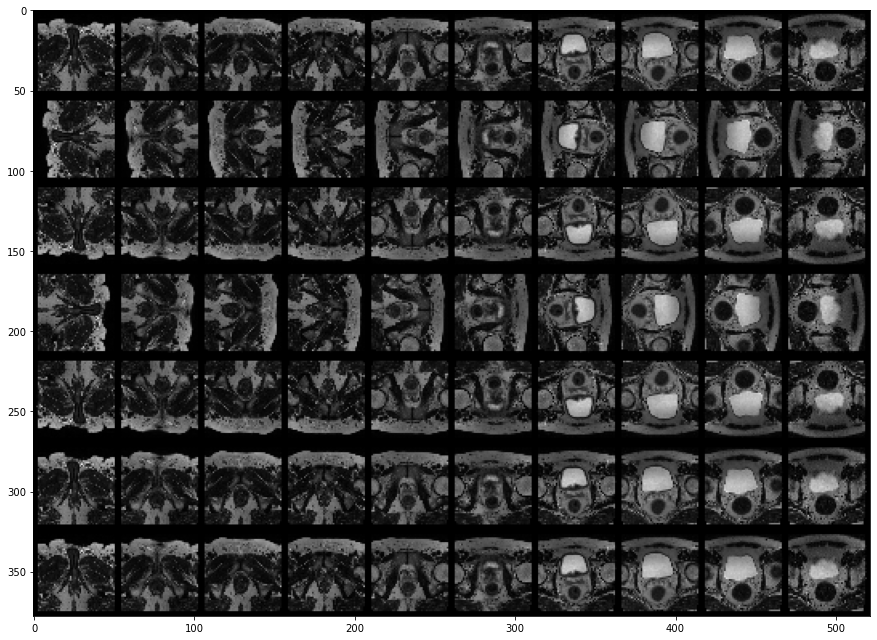

In [11]:
rotator = RandomRotate3D()
show_multiple_3d_images(torch.stack((im, rotate_90_3d(im), rotate_180_3d(im), rotate_270_3d(im), 
                                   rotator(im, split_idx = 0),  rotator(im, split_idx = 0),  rotator(im, split_idx = 0))))

In [12]:
# export

@patch
def rotate_3d_by(t: TensorDicom3D, angle: (int, float), axes: list):
    '''rotates 2D slices of a 3D tensor. 
    Args: 
        t: a TensorDicom3D object or torch.tensor
        angle: the angle to rotate the image 
        axes: axes to which the rotation should be applied. 
        
    Example: 
        If the tensor `t` has the shape of (10, 512, 512), which is equal to 10 slices of 512x512 px. 
        
    rotate_3d_by(t, angle = -15.23, axes = [1,2]) will rotate each slice for -15.23 degrees.   
    
    '''
    rot_t = torch.from_numpy(ndimage.rotate(t.cpu(), angle, axes, reshape=False))
    return retain_type(rot_t, typ = TensorDicom3D)


class RandomRotate3DBy(RandTransform):
    "Randomly flip rotates the axial slices of the 3D image 90/180 or 270 degrees with probability `p`"
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.angle = random.randint(-10, 10)  # add a random integer for axis to rotate
        self.axes = random.choice([[0,1],[1,2],[0,2]])
        
    def encodes(self, x:TensorDicom3D): 
        if x.ndim == 4: self.axes = [x+1 for x in self.axes]
        x = x.rotate_3d_by(angle=self.angle, axes=self.axes)
        return x if x.device.type == 'cpu' else x.cuda()

In [13]:
rotator_by = RandomRotate3DBy()

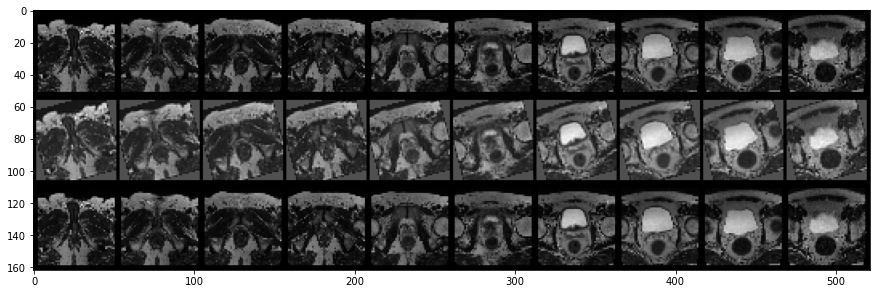

In [14]:
show_multiple_3d_images(torch.stack((im, rotate_3d_by(im, angle = 15, axes = [1,2]), rotator_by(im, split_idx = 0))))

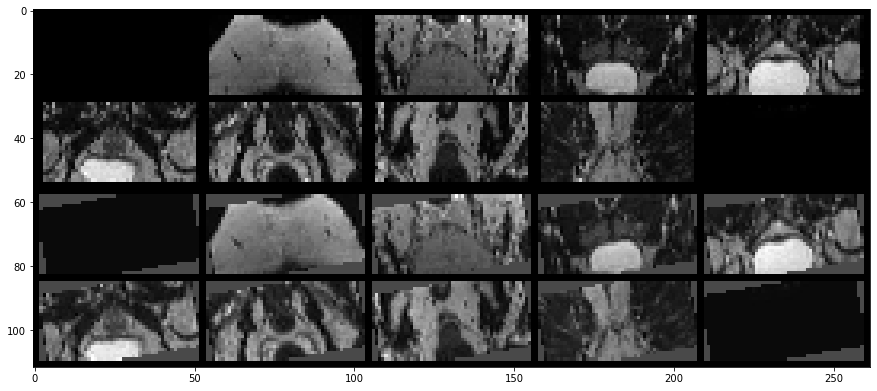

In [15]:
im2 = resize_3d_tensor(read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM', return_normalized = True), (25, 10, 50))
show_multiple_3d_images(torch.stack((im2, rotate_3d_by(im2, angle =10, axes = [0,2]))), axis =1, nrow = 5)

Rotating by 90 (or 180 and 270) degrees should not be done via `rotate_3d_by` but by `rotate_90_3d`, is approximatly 28 times faster.

## Dihedral transformation

As the 3D array can be flipped by three sides, but should only be rotated along the z axis, this is not a complete dihedral group. Still multiple combinations of flipping and rotating should be implemented:

0. original (= flipp ll, roate 180 = same as original image)
1. rotate 90 
2. rotate 180
3. rotate 270
4. flip ll (=flip ap, rotate 180)
5. flip ap
6. flip cc
7. flip cc, rotate 90
8. flip cc, rotate 180
9. flip cc, rotate 270
10. flip ll, rotate 90
11. flipp ll, rotate 270
12. flip ap, rotate 90
13. flip ap rotate 270
14. flip cc, flip ll, rotate 90
15. flip cc, flipp ll, rotate 270
16. flip cc, flip ap, rotate 90
17. flip cc, flip ap rotate 270

I am not sure if this is complete...

In [16]:
# export

@patch
def dihedral3d(x:TensorDicom3D, k):
    "apply dihedral transforamtions to the 3D Dicom Tensor"
    if k in [6,7,8,9,14,15,16,17]: x = x.flip(-3)
    if k in [4,10,11,14,15]: x = x.flip(-1)
    if k in [5,12,13,16,17]: x = x.flip(-2)
    if k in [1,7,10,12,14,16]: 
        if x.ndim == 3: x = x.transpose(1, 2)
        else: x = x.transpose(2,3)
    if k in [2,8]: x = x.flip(-1).flip(-2)
    if k in [3,11,13,15,17]: 
        if x.ndim == 3: x = x.transpose(1, 2).flip(-1)
        else: x = x.transpose(2,3).flip(-1)
    return x

class RandomDihedral3D(RandTransform):
    "randomly flip and rotate the 3D Dicom volume with a probability of `p`"
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.k = random.randint(0,17)
    
    def encodes(self, x:TensorDicom3D): 
        x = x.dihedral3d(self.k)
        return x if x.device.type == 'cpu' else x.cuda()

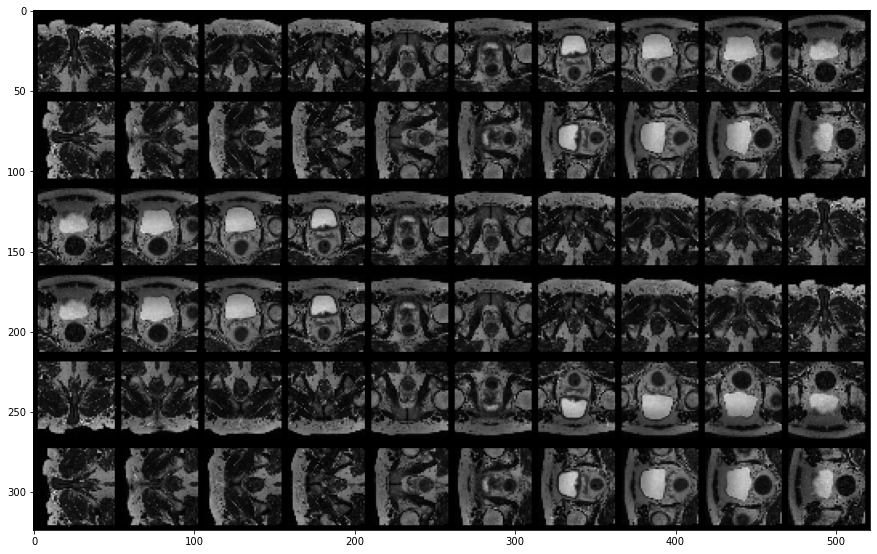

In [17]:
dihedral = RandomDihedral3D()
show_multiple_3d_images(torch.stack((im, dihedral(im, split_idx = 0), dihedral(im, split_idx = 0), 
                                    dihedral(im, split_idx = 0),dihedral(im, split_idx = 0), 
                                    dihedral(im, split_idx = 0))))

## Random Crop

A reasonable approach for 3D medical images would be a presizing to uniform but to large volume and subsequent random cropping to the target dimension. As most areas of interest are located centrally in the image/volume some cropping can always be applied.  
Also random cropping should be applied after any rotation, that is not in 90/180/270 degrees, so that empty margins are cropped.

In [18]:
# export

@patch
def crop_3d(t: TensorDicom3D, margins: (int, float), perc_margins = False):
    "Similar to function `crop_3d_tensor`, but no checking for margin formats is done, as they were correctly passed to this function by RandomCrop3D.encodes"    
    
    if t.ndim not in (3,4): raise TypeError('Tensor of size 3 or 4 expected, but got Tensor of size {} with shape {}'.format(t.ndim, t.shape))
    if t.ndim == 3: 
        x, y, z = t.shape
    else: 
        _, x, y, z = t.shape
    x1,x2,y1,y2,z1,z2 = margins
    
    if perc_margins: 
        if not all(isinstance(i, float) for i in [x1,x2,y1,y2,z1,z2]): raise ValueError('percentage margins should be a float value between 0 and 0.5')
        x1,x2,y1,y2,z1,z2 = int(x1*x),int(x2*x),int(y1*y),int(y2*y),int(z1*z),int(z2*z)
    
    if t.ndim == 3: 
        return retain_type(t[x1:x-x2, y1:y-y2, z1:z-z2], typ = TensorDicom3D)    
    else: 
        return t[:,x1:x-x2, y1:y-y2, z1:z-z2]
    

class RandomCrop3D(RandTransform):
    '''
    Randomly crop the 3D volume with a probability of `p`
    The x axis is the "slice" axis, where no cropping should be done by default
    '''
    split_idx, p = None, 1
    def __init__(self, final_margins, crop_by, perc_margins=False, p=1, **kwargs): 
        super().__init__(p=p,**kwargs)
        self.p = p
        self.final_margins = final_margins
        self.perc_margins = perc_margins
        self.crop_by_x, self.crop_by_y, self.crop_by_z = crop_by
        
#    def __call__(self, b, split_idx=None, **kwargs):
#        "change in __call__ to enforce, that the Transform is always applied on every dataset. "
#        return super().__call__(b, split_idx=split_idx, **kwargs) 
        
    def encodes(self, x:TensorDicom3D): 
        if self.p < 0.5: self.margins = self.final_margins
        else:
            if type(self.final_margins) is tuple and len(self.final_margins) == 3:
                cropx, cropy, cropz = self.final_margins
                try: 
                    if len(cropx) == 2:
                        x1,x2 = cropx
                    if len(cropx) == 2:
                        y1,y2 = cropy
                    if len(cropx) == 2:
                        z1,z2 = cropz
                except:
                    x1,x2,y1,y2,z1,z2 = cropx, cropx, cropy, cropy, cropz, cropz
                    
                self.x_add = random.randint(-self.crop_by_x,self.crop_by_x) 
                self.y_add = random.randint(-self.crop_by_y,self.crop_by_y) 
                self.z_add = random.randint(-self.crop_by_z,self.crop_by_z) 

                self.margins = (x1+self.x_add, x2-self.x_add,y1+self.y_add, y2-self.y_add,z1+self.z_add, z2-self.z_add)

            else:
                raise ValueError('"final_margins" must be a tuple with length 3')

            if any(self.margins) < 0: raise ValueError('cannot crop to a negative dimension')
        
        x = x.crop_3d(margins = self.margins, perc_margins = self.perc_margins)
        return x if x.device.type == 'cpu' else x.cuda()

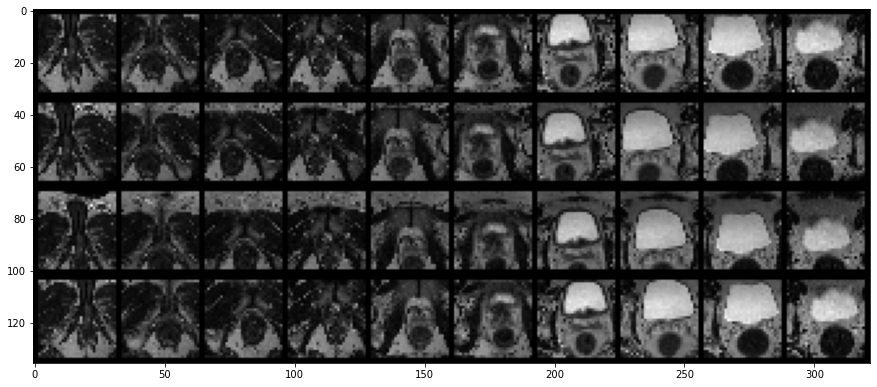

In [19]:
Cropper = RandomCrop3D((0,10,10), (0,5,5), False)

show_multiple_3d_images(torch.stack((Cropper(im, split_idx = 0), Cropper(im, split_idx = 0), 
                                    Cropper(im, split_idx = 0), Cropper(im, split_idx = 0))))

Other cropping methods, with padding, squishing or large maginifcations might not be appropriate for medical images, since often only small areas in the image are of importance which could be removed by cropping (e.g. tumor). So cropping should only be applied to the image margins.  
  
As cropping a resizing are good preprocessing operations, they can be merged into one class, for easier access. 

In [20]:
# export

class ResizeCrop3D(RandTransform):
    split_idx,order = None, 1
    
    "Resize and crop a 3D tensor"
    
    def __init__(self, crop_by, resize_to, perc_crop=False, p=1, **kwargs): 
        resize_to = _process_sz_3d(resize_to)
        crop_by = crop_by
        perc_crop = perc_crop
        store_attr()
        super().__init__(p=p,**kwargs)

    def encodes(self, x:TensorDicom3D): 
        if type(self.crop_by) is tuple and len(self.crop_by) == 3:
            cropx, cropy, cropz = self.crop_by
            try: x1,x2 = cropx
            except: x1,x2 = cropx,cropx
            try: y1,y2 = cropy
            except: y1,y2 = cropy,cropy
            try: z1,z2 = cropz
            except: z1,z2 = cropz,cropz
                    
            self.margins = (x1,x2,y1,y2,z1,z2)

        else: raise ValueError('"crop_by" must be a tuple with length 3 in the form ox (x,y,z) or ((x1,x2),(y1,y2),(z1,z2))')
        if any(self.margins) < 0: raise ValueError('cannot crop to a negative dimension')
    
        x = x.crop_3d(margins = self.margins, perc_margins = self.perc_crop).resize_3d(self.resize_to)
        return x if x.device.type == 'cpu' else x.cuda()

## Warping 

Light wrapping can mimic artifacts in MRI images or breathing artifacts in CT images

In [21]:
# export
@patch
def warp_3d(t: TensorDicom3D):
    
    z,x,y = t.shape # for a reason, I do currently not understand, order of the axis changes from resampling. flipping the order of x,y,z is the current workaround. z axis is now the slice axis
  
    t = torch.stack((t,t,t)) # create fake color channel
    t = t.unsqueeze(0).float() # create batch dim    
    
    magintude_y = random.randint(4, 25)
    magintude_x = random.randint(4, 25) # magnitude 5 is equal magintude 0.2 for fastai warp class
    
    warp_x = random.randint(-x//magintude_x, x//magintude_x) # no warping along the z axis (wraping only on 2D slices)
    warp_y = random.randint(-y//magintude_y, y//magintude_y)
    
    warp_x1 = round(float(x)/2 + warp_x) 
    warp_x2 = x - warp_x1     
    
    warp_y1 = round(float(y)/2 + warp_y) 
    warp_y2 = y - warp_y1

    x = torch.cat(
        (torch.linspace(-1, 0, warp_x1), 
        torch.linspace(0, 1, warp_x2+1)[1:]))
    y = torch.cat(
        (torch.linspace(-1, 0, warp_y1), 
        torch.linspace(0, 1, warp_y2+1)[1:]))# without the +1)[1:] two 0 would be in the merged linspaces
    z = torch.linspace(-1, 1, z) 
    
    meshx, meshy, meshz = torch.meshgrid((x, y, z)) # 
    grid = torch.stack((meshy, meshx , meshz), 3) # create flow field. x and y need to be switched as otherwise the images are rotated. 
    grid = grid.unsqueeze(0) # add batch dim
    if t.device.type == 'cuda': grid = grid.cuda()
        
    out = F.grid_sample(t, grid, align_corners=True, mode = 'bilinear') # rescale the 5D tensor
    out = out[0,0,:,:,:].permute(2,0,1).contiguous() # remove fake color channels and batch dim, reorder the image (the Z axis has moved to the back...)
    return retain_type(out, typ = TensorDicom3D)

@patch
def warp_4d(t: Tensor):
    
    for i in range(0, t.size(0)):
        t[i,:,:,:] = warp_3d(t[i,:,:,:])
    return t
    

class RandomWarp3D(RandTransform):
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        
    def encodes(self, x:TensorDicom3D): 
        x = x.warp_3d() if x.ndim == 3 else x.warp_4d()
        return x if x.device.type == 'cpu' else x.cuda()

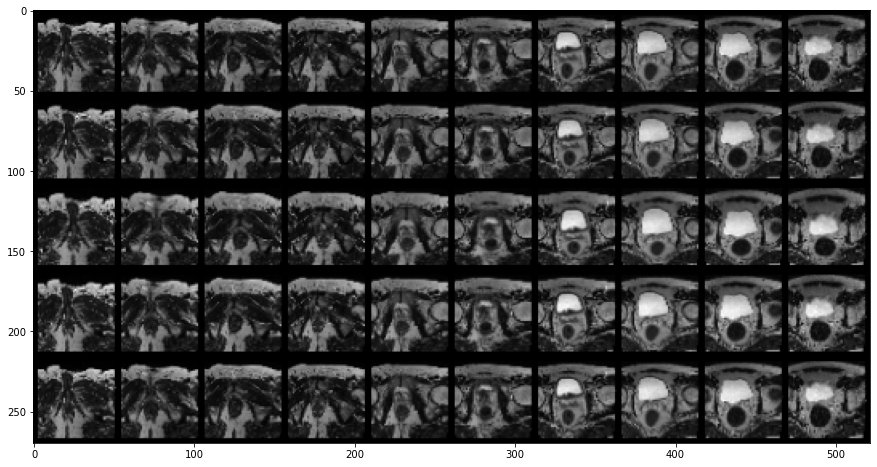

In [22]:
warper = RandomWarp3D(p=1)
show_multiple_3d_images(torch.stack((warper(im, split_idx = 0), warper(im, split_idx = 0), warper(im, split_idx = 0), warper(im, split_idx = 0), warper(im, split_idx = 0))))

## Random Gaussian noise

Older scanners with lower field strength (MRI), fewer slices (CT), older algorithms can be more noise. So adding some random noise to the data, could improve model performance. 

In [23]:
# export

@patch
def add_gaussian_noise(t:TensorDicom3D, std):
    shape = torch.randn(t.shape).cuda() if t.device.type == 'cuda' else torch.randn(t.shape).cpu()
    return t + (std**0.5)*shape
    
class RandomNoise3D(RandTransform):
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        low_std = float(random.randint(1,20))/100
        high_std = float(random.randint(20,30))/100
        self.std = random.choice((low_std, low_std, low_std, low_std, high_std)) # lower noise is oversampled, as high noise migh be bad for the model
        
    def encodes(self, x:TensorDicom3D): 
        x = x.add_gaussian_noise(self.std)
        return x if x.device.type == 'cpu' else x.cuda()

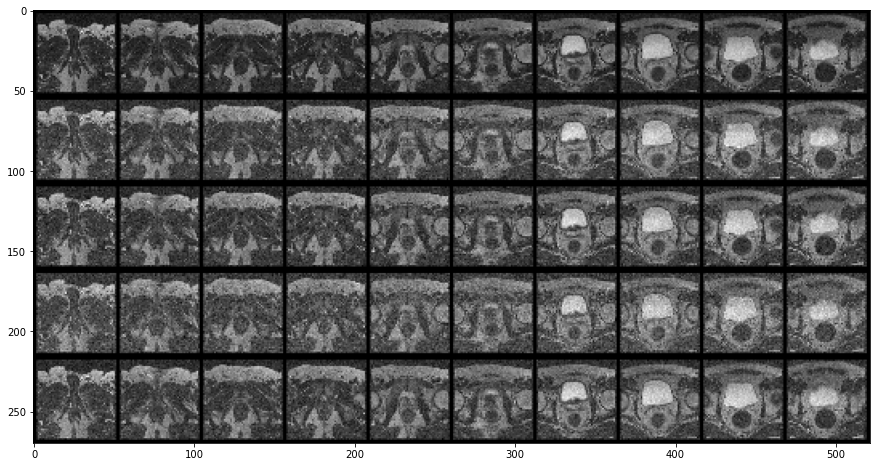

In [24]:
noise_adder = RandomNoise3D(p=1)
show_multiple_3d_images(torch.stack((noise_adder(im, split_idx = 0), noise_adder(im, split_idx = 0), 
                                     noise_adder(im, split_idx = 0), noise_adder(im, split_idx = 0), noise_adder(im, split_idx = 0))))

## Lightning transforms

Simple brightness and contrast controlls can be dona via a linear function: 

    x = alpha * x_i + beta  

here x_i is the respective pixel, alpha allows simple contrast control, beta allows simple brightness control.

In [25]:
# export

@patch
def rescale(t: TensorDicom3D, new_min = 0, new_max = 1):
    return (new_max - new_min)/(t.max()-t.min()) *(t - t.max()) + t.max()    
    
@patch
def adjust_brightness(x:TensorDicom3D, beta):
    return torch.clamp(x + beta, x.min(), x.max())


class RandomBrightness3D(RandTransform):
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.beta = float(random.randint(-300,400))/1000
        
    def encodes(self, x:TensorDicom3D): 
        x = x.adjust_brightness(self.beta)
        return x if x.device.type == 'cpu' else x.cuda()


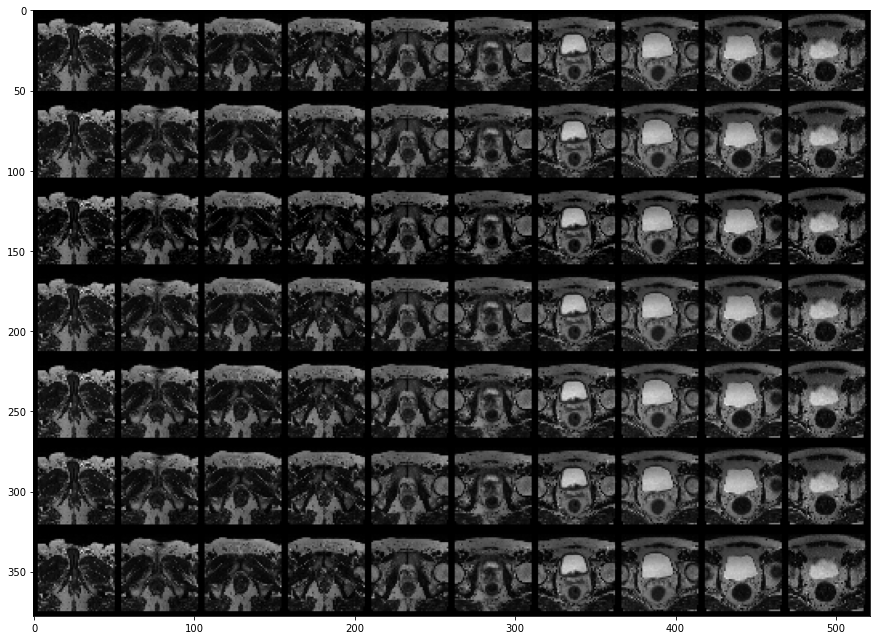

In [26]:
lighting = RandomBrightness3D()
show_multiple_3d_images(torch.stack((im, lighting(im, split_idx = 0), lighting(im, split_idx = 0), 
                                     lighting(im, split_idx = 0), lighting(im, split_idx = 0), 
                                     lighting(im, split_idx = 0), lighting(im, split_idx = 0))))

## Contrast

In [27]:
# export

@patch
def adjust_contrast(x:TensorDicom3D, alpha):
    return torch.clamp(alpha * x, x.min(), x.max())    


class RandomContrast3D(RandTransform):
    def __init__(self, p=0.6): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.alpha = float(random.randint(940, 1150))/1000
        
    def encodes(self, x:TensorDicom3D): 
        x = x.adjust_contrast(self.alpha)
        return x if x.device.type == 'cpu' else x.cuda()

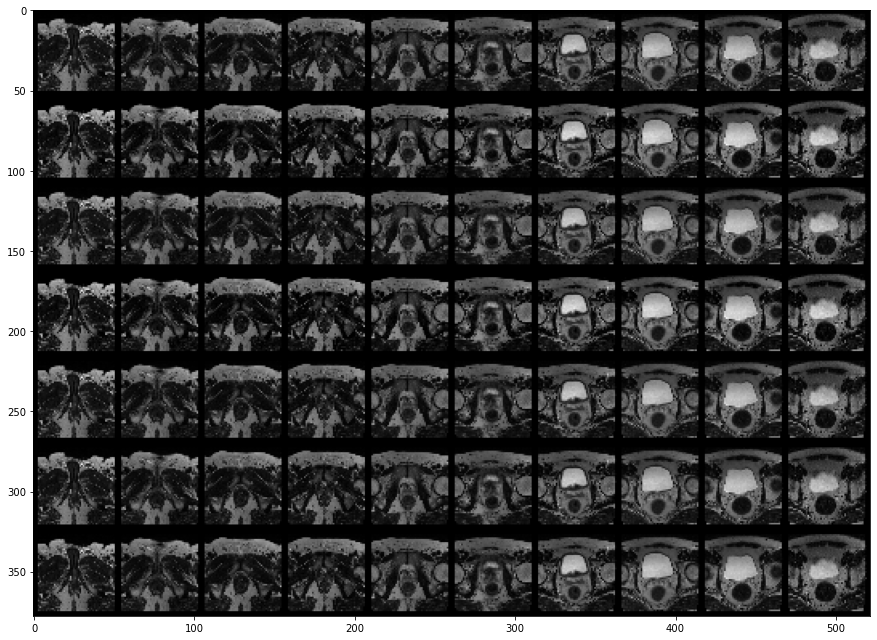

In [28]:
contrast = RandomContrast3D()
show_multiple_3d_images(torch.stack((im, contrast(im, split_idx = 0), contrast(im, split_idx = 0), 
                                     contrast(im, split_idx = 0), contrast(im, split_idx = 0), 
                                     contrast(im, split_idx = 0), contrast(im, split_idx = 0))))

## Random ereasing 

Random ereasing, as shown in the fastaivision.augment docs might not be optimal, because it could erease the important image findings, such as a nodule. Just ereasing random pixel could be an option, but I belive this would not be different from using dropout while training a model?

## Putting it all together

A good workflow would be to apply random crop to all images after one transformation. For this, the images should be presized to a size, just some pixels larger then desired, then transformed and then cropped to the final size. Using this approach empty space, which e.g. appears after `RandomRotate3DBy` will be cropped and not influence the accuracy of the model. One only has to be careful, that the region of interest, e.g. the prostate, will be in every cropped image. 

In [29]:
im = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM', return_normalized = True)
im = resize_3d_tensor(im, (30, 250, 250)) # presizing the images

Cropper = RandomCrop3D((5,50,50), (1,5,5))

tfms = [RandomBrightness3D(), RandomContrast3D(), RandomWarp3D(), RandomDihedral3D(), RandomNoise3D(), RandomRotate3DBy()]
tfms = [Pipeline([RandomBrightness3D, Cropper], split_idx = 0), 
        Pipeline([RandomContrast3D, Cropper], split_idx = 0), 
        Pipeline([RandomWarp3D, Cropper], split_idx = 0), 
        Pipeline([RandomDihedral3D, Cropper], split_idx = 0), 
        Pipeline([RandomNoise3D, Cropper], split_idx = 0), 
        Pipeline([RandomRotate3DBy, Cropper], split_idx = 0)]

In [30]:
comp = setup_aug_tfms(tfms)

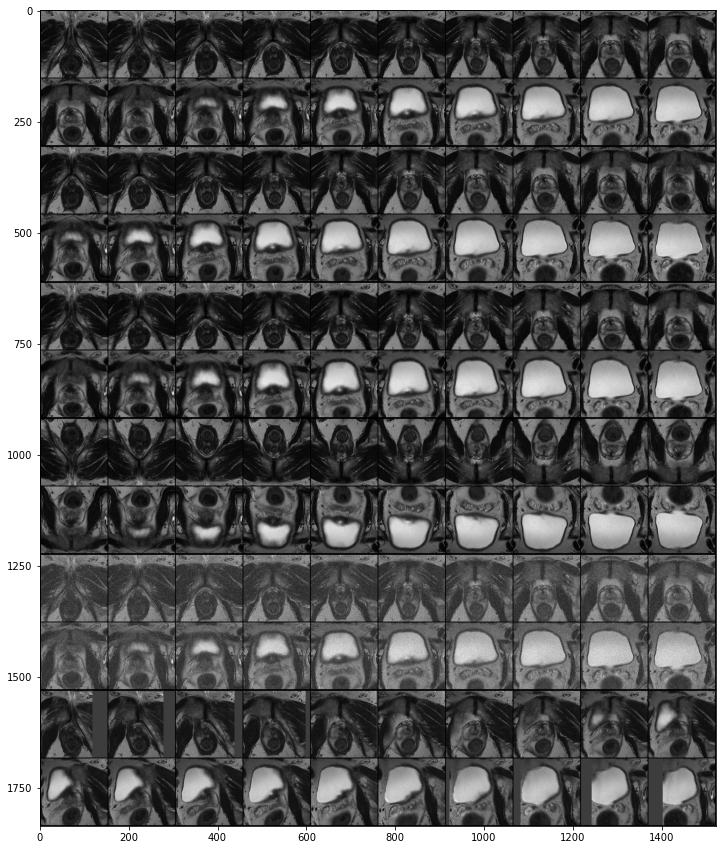

In [31]:
ims = [t(im) for t in tfms]
show_multiple_3d_images(torch.stack(ims))

## Creating a pseudo color channel

Many models require 3 channels for color. If possible, the 3D image is stacked to three color channels. 

In [32]:
#export

@patch
def make_pseudo_color(t: (Tensor, TensorDicom3D)): 
    '''
    The 3D CNN still expects color images, so a pseudo color image needs to be created as long as I don't adapt the 3D CNN
    '''
    return torch.stack((t, t, t), t.ndim).float() if t.ndim in (3,4) else t # permute is an important step, ensuring rigth format of tensors

class PseudoColor(RandTransform):
    split_idx, p = None, 1
    
    def __init__(self, p=1): 
        super().__init__(p=p)

    def __call__(self, b, split_idx=None, **kwargs):
        "change in __call__ to enforce, that the Transform is always applied on every dataset. "
        return super().__call__(b, split_idx=split_idx, **kwargs) 
    
    def encodes(self, x:(TensorDicom3D, Tensor)): 
        x = x.make_pseudo_color()
        return x if x.device.type == 'cpu' else x.cuda()

In [33]:
MakeColor = PseudoColor()
im.shape, MakeColor(im, split_idx = 0).shape

(torch.Size([30, 250, 250]), torch.Size([30, 250, 250, 3]))

In [34]:
# export

def _set_p_tfms(p, p_all):
    return p_all if p is None else p

In [35]:
# export

def aug_transforms_3d(p_all = 0.1, 
                      do_warp = True, p_warp = None, 
                      do_dihedral = True, p_dihedral = None, 
                      do_brightness = True, p_brightness = None, 
                      do_contrast = True, p_contrast = None,
                      do_noise = True, p_noise = None,
                      do_rotate_by = True, p_rotate_by = None,
                      do_flip = True, p_flip = None, 
                      do_rotate = True, p_rotate = None,
                      do_crop = True, p_crop = 1):
    tfms = []
    
    if do_warp: tfms.append(RandomWarp3D(p=_set_p_tfms(p_warp, p_all))) 
    if do_dihedral: tfms.append(RandomDihedral3D(p=_set_p_tfms(p_dihedral, p_all))) 
    if do_brightness: tfms.append(RandomBrightness3D(p=_set_p_tfms(p_brightness, p_all))) 
    if do_contrast: tfms.append(RandomContrast3D(p=_set_p_tfms(p_contrast, p_all))) 
    if do_noise: tfms.append(RandomNoise3D(p=_set_p_tfms(p_noise, p_all))) 
    if do_rotate_by: tfms.append(RandomRotate3DBy(p=_set_p_tfms(p_rotate_by, p_all))) 
    if do_flip: tfms.append(RandomFlip3D(p=_set_p_tfms(p_flip, p_all))) 
    if do_rotate: tfms.append(RandomRotate3D(p=_set_p_tfms(p_rotate, p_all))) 
    
    return tfms

In [36]:
aug_transforms_3d()

[RandomWarp3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomDihedral3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomBrightness3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomContrast3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomNoise3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomRotate3DBy -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomFlip3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ,
 RandomRotate3D -- {'p': 0.1}:
 encodes: (TensorDicom3D,object) -> encodes
 decodes: ]